**Importing Libraries**

In [1]:
!pip install scikit-learn
!pip install scikit-learn-intelex


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 11.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearnex import patch_sklearn, unpatch_sklearn
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("/content/autism_data.csv")

# Display the first 5 rows of the dataset
display(data.head(5))


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2.0,18 and more,?,NO


In [3]:
# Remove missing values
data.dropna(inplace=True)

# Convert categorical data to numerical (One-Hot Encoding)
data_raw = data['Class/ASD']
features_raw = data[['age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'result',
                      'relation','A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score',
                      'A9_Score','A10_Score']]

# Apply MinMaxScaler to numerical features
scaler = MinMaxScaler()
num = ['age','result']
features_raw[num] = scaler.fit_transform(features_raw[num])

# One-hot encoding for categorical variables
features_final = pd.get_dummies(features_raw)

# Encode labels
data_classes = data_raw.apply(lambda x: 1 if x == 'YES' else 0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, data_classes, test_size=0.2, random_state=42)


<ipython-input-3-966acf75c983>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_raw[num] = scaler.fit_transform(features_raw[num])


In [11]:
# Unpatch Intel OneAPI for this part
unpatch_sklearn()

# Train a Random Forest model without Intel OneAPI extensions
model = RandomForestClassifier(random_state=42)

start_time = time()
model.fit(X_train, y_train)
end_time = time()

# Predicting the Test set results
y_pred = model.predict(X_test)

# Calculate accuracy and training time
accuracy = accuracy_score(y_test, y_pred)
train_time_no_oneapi = end_time - start_time

print(f"Without Intel OneAPI - Accuracy: {accuracy:.4f}, Training time: {train_time_no_oneapi:.4f} seconds")

Without Intel OneAPI - Accuracy: 1.0000, Training time: 0.2986 seconds


In [5]:
# Patch Intel OneAPI for this part
patch_sklearn()

# Train the same Random Forest model with Intel OneAPI extensions
model_oneapi = RandomForestClassifier(random_state=42)

start_time = time()
model_oneapi.fit(X_train, y_train)
end_time = time()

# Predicting the Test set results
y_pred_oneapi = model_oneapi.predict(X_test)

# Calculate accuracy and training time
accuracy_oneapi = accuracy_score(y_test, y_pred_oneapi)
train_time_oneapi = end_time - start_time

print(f"With Intel OneAPI - Accuracy: {accuracy_oneapi:.4f}, Training time: {train_time_oneapi:.4f} seconds")


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


With Intel OneAPI - Accuracy: 1.0000, Training time: 0.5824 seconds


In [6]:
print("\n--- Comparison ---")
print(f"Without Intel OneAPI - Training time: {train_time_no_oneapi:.4f} seconds")
print(f"With Intel OneAPI    - Training time: {train_time_oneapi:.4f} seconds")

speedup = train_time_no_oneapi / train_time_oneapi
print(f"Speedup with Intel OneAPI: {speedup:.2f}x")


--- Comparison ---
Without Intel OneAPI - Training time: 1.0087 seconds
With Intel OneAPI    - Training time: 0.5824 seconds
Speedup with Intel OneAPI: 1.73x


<ipython-input-12-2c1de939c6a9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Method', y='Training Time (seconds)', data=df, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


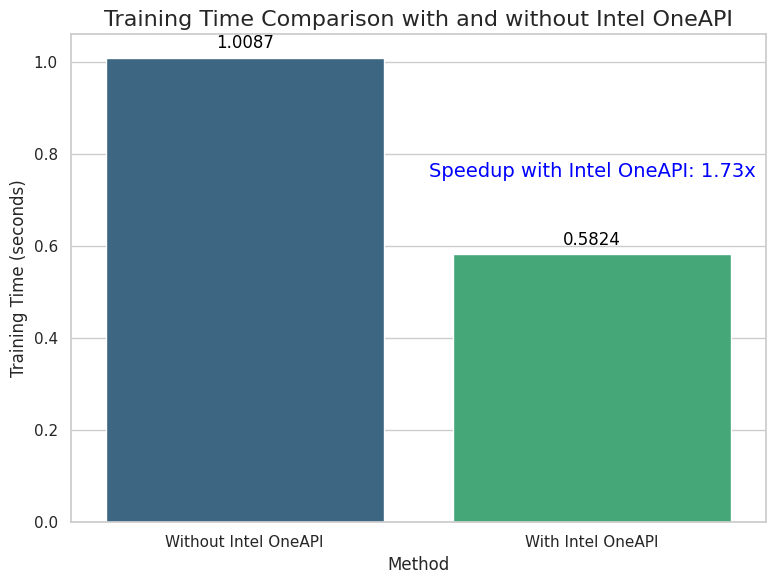

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Method': ['Without Intel OneAPI', 'With Intel OneAPI'],
    'Training Time (seconds)': [1.0087, 0.5824]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Method', y='Training Time (seconds)', data=df, palette='viridis')

# Annotate the bars with the training times
for index, value in enumerate(df['Training Time (seconds)']):
    bar_plot.text(index, value + 0.02, f'{value:.4f}', color='black', ha="center")

# Title and labels
plt.title('Training Time Comparison with and without Intel OneAPI', fontsize=16)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.xlabel('Method', fontsize=12)

# Add the speedup annotation
speedup = 1.73
plt.text(1, 0.75, f'Speedup with Intel OneAPI: {speedup}x', color='blue', fontsize=14, ha='center')

# Show plot
plt.tight_layout()
plt.show()
